# Fisher's Exact Test for Proportions
> Use Case
- Fisher's exact test is ideal for A/B hypothesis testing when dealing with small sample sizes and categorical data in a 2x2 contingency table, however it can also be used with large sample sizes. 
- It is typically used to determine whether there is a significant association between two categorical variables, such as treatment and outcome.
- It provides exact results rather than approximations like the Chi-Squared test.
> Assumptions
- Independence: The observations in each group are independent of each other.
- 2x2 Contingency Table: The test is designed to handle two categorical variables with two levels each.
- Small Sample Size: Unlike the Chi-Squared test, Fisher's exact test can handle small sample sizes effectively, which makes it useful in scenarios where expected counts are low.
- No Homogeneity Assumptions: The test does not require equal variance across groups.
> Example Scenario
- A company is testing two versions of an email marketing campaign (A and B) to determine which one yields a higher response rate. The response (open or not open) is recorded for each email recipient, creating a 2x2 contingency table. The company wants to determine if there is a significant difference in the response rates between the two campaigns.
> Null Hypothesis (H0):
- The null hypothesis is that there is no association between the treatment (email campaigns A and B) and the outcome (response rates). This implies that the proportions of responses are the same for both campaigns.
> Alternative Hypothesis (H1):
- The alternative hypothesis is that there is a significant association between the treatment and the outcome, indicating a difference in response rates between the two campaigns.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import fisher_exact, barnard_exact, boschloo_exact, norm

# !pip install statsmodels==0.12.2
from statsmodels.stats.proportion import proportion_effectsize


/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_55564/2033406849.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/544

In [3]:
# Set random seed for reproducibility
np.random.seed(1)

In [4]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'tab:orange'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False 

### Power Analysis

In [5]:
# Function to simulate Fisher's exact test
def simulate_fisher(n_samples, p1, p2, alpha):
    """Simulates Fisher's exact test and returns True if p-value < alpha."""
    group1_success = np.random.binomial(n_samples, p1)
    group2_success = np.random.binomial(n_samples, p2)
    
    # 2x2 contingency table
    contingency_table = np.array([
        [group1_success, n_samples - group1_success],
        [group2_success, n_samples - group2_success]
    ])
    
    _, p_value = fisher_exact(contingency_table)
    return p_value < alpha

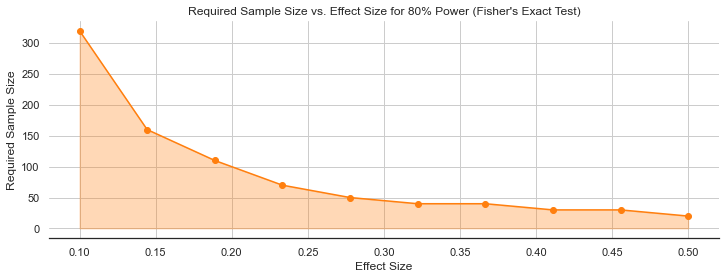

In [6]:


# Simulation parameters
alpha = 0.05  # Significance level
desired_power = 0.8  # Desired power level
max_samples = 1000  # Maximum sample size to consider in simulations
n_simulations = 1000  # Number of simulations to estimate power
effect_sizes = np.linspace(0.1, 0.5, 10)  # Range of effect sizes to test
baseline_p = 0.2 # The historical probability (CTR, etc...) of the control group


# Determine required sample size for each effect size
sample_sizes = np.arange(10, max_samples + 10, 10)  # Sample sizes in steps of 10
required_sample_sizes = []

for effect_size in effect_sizes:
    # Define probabilities for the groups based on effect size
    p1 = baseline_p  # Baseline probability
    p2 = p1 + effect_size  # Probability for the second group
    
    # Find the minimum sample size to achieve the desired power
    power_reached = False
    for sample_size in sample_sizes:
        rejections = [simulate_fisher(sample_size, p1, p2, alpha) for _ in range(n_simulations)]
        power = sum(rejections) / n_simulations
        
        if power >= desired_power:
            required_sample_sizes.append(sample_size)
            break

# Plot effect sizes against required sample sizes
plt.figure(figsize=(12, 4))
plt.plot(effect_sizes, required_sample_sizes, marker='o', linestyle='-', color=color, label='Required Sample Size')
plt.fill_between(effect_sizes, required_sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Effect Size for 80% Power (Fisher\'s Exact Test)')
plt.xlabel('Effect Size')
plt.ylabel('Required Sample Size')
plt.grid(True)
plt.show()


In [7]:

# Simulation parameters
alpha = 0.05  # Significance level
desired_power = 0.8  # Desired power level
max_samples = 1000  # Maximum sample size to consider in simulations
n_simulations = 1000  # Number of simulations to estimate power
effect_size = 0.15  # You can adjust this depending on your expected effect size
baseline_p = 0.2 # The historical probability (CTR, etc...) of the control group
estimated_p = baseline_p + effect_size # The estimated probability (CTR, etc...) of the new group

# Simulation-based power analysis
sample_sizes = np.arange(10, max_samples + 10, 10)  # Increasing sample sizes in steps of 10
powers = []

for sample_size in sample_sizes:
    # Simulate Fisher's exact test 1000 times to estimate power
    rejections = [simulate_fisher(sample_size, baseline_p, estimated_p, alpha) for _ in range(1000)]
    power = sum(rejections) / 1000  # Proportion of rejections is the power
    powers.append(power)

# Determine the minimum sample size to achieve the desired power
min_sample_size = sample_sizes[np.where(np.array(powers) >= desired_power)[0][0]]

print("Sample Size to Achieve Desired Power:", min_sample_size)


Sample Size to Achieve Desired Power: 160


### Synthetic Data

In [8]:
# Define the number of samples for each version
n_samples = 200

# Generate synthetic data for two website versions
version_A = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.8, 0.2])
version_B = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.75, 0.25])

# Create pandas dataframe
fischers_data = pd.DataFrame({'Version_A': version_A, 'Version_B': version_B})

fischers_data

,Version_A,Version_B
0,Satisfied,Not Satisfied
1,Satisfied,Satisfied
2,Satisfied,Not Satisfied
3,Not Satisfied,Not Satisfied
4,Not Satisfied,Not Satisfied
...,...,...
195,Satisfied,Satisfied
196,Satisfied,Satisfied
197,Satisfied,Satisfied
198,Satisfied,Satisfied


### Check Assumptions

In [9]:
# Contingency table (the wrong way - this is paired samples)
observed_counts = pd.crosstab(fischers_data['Version_A'], fischers_data['Version_B'])
observed_counts

Version_B,Not Satisfied,Satisfied
Version_A,,
Not Satisfied,14,23
Satisfied,50,113


In [10]:
# Contingency table (the right way - this is independent counts)
observed_counts = fischers_data.melt().rename(columns = {'variable':'Group', 'value':'Satisfied'})
observed_counts = pd.crosstab(observed_counts['Group'], observed_counts['Satisfied'])
observed_counts

Satisfied,Not Satisfied,Satisfied
Group,,
Version_A,37,163
Version_B,64,136


In [11]:
observed_counts = observed_counts.sample(frac=1)
observed_counts

Satisfied,Not Satisfied,Satisfied
Group,,
Version_B,64,136
Version_A,37,163


In [12]:
# Print the contingency table
print("Contingency Table:")
display(observed_counts)

# Check if the table is 2x2
if observed_counts.shape == (2, 2):
    print("The contingency table is 2x2.")
else:
    print("The contingency table is not 2x2.")

Contingency Table:


Satisfied,Not Satisfied,Satisfied
Group,,
Version_B,64,136
Version_A,37,163


The contingency table is 2x2.


### Fishers's Test (scipy)

In [13]:
# Pre-determined alpha
alpha = 0.05  

In [14]:

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(observed_counts, alternative='two-sided')

# Print the odds ratio and p-value
print("Fisher's Exact Test Results:")
print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")


# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "There is a significant difference in the proportions between Group A and Group B."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in proportions between Group A and Group B."
print("\n")
print(conclusion)
print(interpretation)

Fisher's Exact Test Results:
Odds Ratio: 2.0731319554848966, P-value: 0.002664878853259856


Reject the null hypothesis.
There is a significant difference in the proportions between Group A and Group B.


### Barnard's Exact Test (SciPy)

In [24]:
# Perform Barnard's exact test
ber = barnard_exact(observed_counts, alternative='two-sided', pooled=True, n=32)

wald_statistic = ber.statistic
p_value = ber.pvalue


# Print the odds ratio and p-value
print("Barnard's Exact Test Results:")
print(f"Wald Statistic: {odds_ratio}, P-value: {p_value}")


# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "There is a significant difference in the proportions between Group A and Group B."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in proportions between Group A and Group B."
print("\n")
print(conclusion)
print(interpretation)

Barnard's Exact Test Results:
Wald Statistic: 0.001332439426629928, P-value: 0.002419508251180009


Reject the null hypothesis.
There is a significant difference in the proportions between Group A and Group B.


### Boschloo's Exact Test (SciPy)

In [25]:

# Perform Boschloo's exact test
ber = boschloo_exact(observed_counts, alternative='two-sided', n=32)

statistic = ber.statistic
p_value = ber.pvalue

# Print the odds ratio and p-value
print("Boschloo's Exact Test Results:")
print(f"Statistic: {statistic}, P-value: {p_value}")


# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "There is a significant difference in the proportions between Group A and Group B."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in proportions between Group A and Group B."
print("\n")
print(conclusion)
print(interpretation)

Boschloo's Exact Test Results:
Statistic: 0.001332439426629928, P-value: 0.0019566455269045347


Reject the null hypothesis.
There is a significant difference in the proportions between Group A and Group B.


### 95% Confidence Interval

In [111]:
# For 95% confidence interval
confidence_level = 0.95

# Proportions of satisfied users
p1 = (fischers_data['Version_B'] == 'Satisfied').mean()
p2 = (fischers_data['Version_A'] == 'Satisfied').mean()


# Total number of samples in each group
n1 = n_samples
n2 = n_samples

# Calculate the difference in proportions
diff_proportions = p2 - p1

# Calculate the standard error for the difference in proportions
standard_error = np.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))

# Calculate the margin of error (1.96 for 95% confidence interval)
margin_of_error = norm.ppf(1 - (1 - confidence_level) / 2) * standard_error  

# Calculate the 95% confidence interval
lower_bound = diff_proportions - margin_of_error
upper_bound = diff_proportions + margin_of_error


# Print results
print(f"Difference in Proportions: {diff_proportions}")
print(f"95% Confidence Interval of the Difference in Proportions: [{lower_bound}, {upper_bound}]")


Difference in Proportions: 0.1349999999999999
95% Confidence Interval of the Difference in Proportions: [0.05088408613486975, 0.21911591386513005]


### Effect Size

In [116]:

# Cohen's h effect size
h = abs(proportion_effectsize(p1, p2, method='normal'))
# h = np.abs((2*np.arcsin(np.sqrt(p1))) - (2*np.arcsin(np.sqrt(p1))))

print(f"Cohen's h Effect Size: {h}")
print("\n")

if h == 0:
    print("There is no difference between the two groups.")
elif h <= 0.2:
    print("There is a small difference between the two groups.")
elif h <= 0.5:
    print("There is a moderate difference between the two groups.")
elif h <= 0.8:
    print("There is a large difference between the two groups.")
else:
    print("There is a very large difference between the two groups.")


Cohen's h Effect Size: 0.31328531812647675


There is a moderate difference between the two groups.


### Odds Ratio

In [117]:

# Odds Ratio
print(f"The odds ratio is {round(odds_ratio, 4)}")
print(f"The odds of the outcome are {round(odds_ratio, 4)} times as high in the exposed group compared to the unexposed group.")
print("\n")

if odds_ratio > 1:
    print("This suggests a positive association between the exposure and the outcome.\nIt means that the odds of the outcome occurring in the exposed group are higher than the odds of the outcome occurring in the unexposed group. ")
elif odds_ratio < 1:
    print("This implies a negative association between the exposure and the outcome.\nIt indicates that the odds of the outcome occurring in the exposed group are lower than the odds of the outcome occurring in the unexposed group.")
else:
    print("This indicates no association between the exposure and the outcome.\nIn other words, the odds of the outcome occurring in the exposed group are the same as the odds of the outcome occurring in the unexposed group.")

The odds ratio is 2.0731
The odds of the outcome are 2.0731 times as high in the exposed group compared to the unexposed group.


This suggests a positive association between the exposure and the outcome.
It means that the odds of the outcome occurring in the exposed group are higher than the odds of the outcome occurring in the unexposed group. 


### Summary Table

In [118]:
# Count everything up
total_count = fischers_data.size
group_a_count = fischers_data['Version_A'].count()
group_b_count = fischers_data['Version_B'].count()

group_a_positive_count = len(fischers_data[fischers_data['Version_A'] == 'Satisfied'])
group_a_negative_count = len(fischers_data[fischers_data['Version_A'] == 'Not Satisfied'])
group_b_positive_count = len(fischers_data[fischers_data['Version_B'] == 'Satisfied'])
group_b_negative_count = len(fischers_data[fischers_data['Version_B'] == 'Not Satisfied'])

In [119]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Intervention Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Satisfied': [group_a_positive_count, group_b_positive_count],
    'Not Satisfied': [group_a_negative_count, group_b_negative_count],
    'Satisfaction Rate': [group_a_positive_count/group_a_count, group_b_positive_count/group_b_count],
}, index=[0, 1])
plot_data

,Intervention Group,Total,Satisfied,Not Satisfied,Satisfaction Rate
0,Group A,200,163,37,0.815
1,Group B,200,136,64,0.680


### Visualization

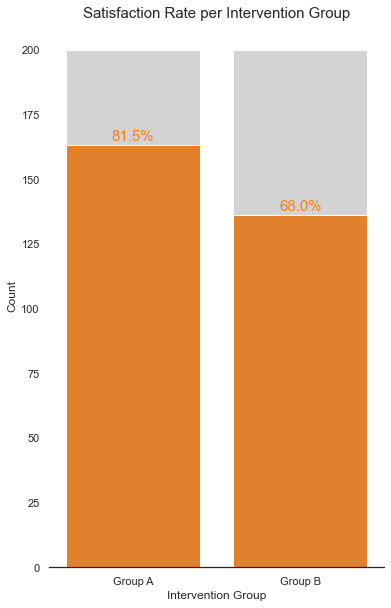

In [129]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Intervention Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Intervention Group'], 
                            y=plot_data['Satisfied'], color=color)

# Set labels and title
plt.title('Satisfaction Rate per Intervention Group', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Intervention Group'] == 'Group A'][['Satisfied', 'Satisfaction Rate']].iterrows():
    plot_total.text(row.name, row['Satisfied']+2, str(round(100 * row['Satisfaction Rate'], 2)) + '%', color=color, ha="center", fontsize=15)
for index, row in plot_data[plot_data['Intervention Group'] == 'Group B'][['Satisfied', 'Satisfaction Rate']].iterrows():
    plot_satisfied.text(row.name, row['Satisfied']+2, str(round(100 * row['Satisfaction Rate'], 2)) + '%', color=color, ha="center", fontsize=15)


# Show the plot
plt.show()